# Transfer Learning with Tensorflow Part 2: Fine-tuning.

## Create helper functions

There are some functions we need to use in most of our notebooks and writting all of them is tedious
And we can use a .py file for save and import them

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-25 08:35:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-25 08:35:46 (97.6 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem

In [ ]:
# Get 10% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-08-25 08:35:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 142.250.159.128, 142.251.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   209MB/s    in 0.8s    

2023-08-25 08:35:47 (209 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [ ]:
# Create training and test directory path

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[9.00000000e+00 6.00000000e+00 2.57142849e+01]
   [6.71428537e+00 4.64285707e+00 1.89999981e+01]
   [4.58163261e+00 3.58163261e+00 1.11530609e+01]
   ...
   [9.05103607e+01 5.97297211e+01 5.13724480e+01]
   [8.77601700e+01 5.78112183e+01 4.41428452e+01]
   [7.59696579e+01 4.79697266e+01 3.59696922e+01]]

  [[6.76020384e+00 5.40306091e+00 2.44744892e+01]
   [5.00510216e+00 4.00510216e+00 1.81581631e+01]
   [9.35714340e+00 8.35714340e+00 1.59285717e+01]
   ...
   [7.37246017e+01 5.03367653e+01 3.90662880e+01]
   [8.04999466e+01 5.92907906e+01 4.24285431e+01]
   [7.10256500e+01 5.36225929e+01 3.77654495e+01]]

  [[1.16326532e+01 1.06326532e+01 2.86326523e+01]
   [3.19897890e+00 2.19897890e+00 1.63418350e+01]
   [4.40306091e+00 2.95408154e+00 1.31428566e+01]
   ...
   [5.86631050e+01 4.30916328e+01 2.89486885e+01]
   [6.54794846e+01 5.04540100e+01 3.20662498e+01]
   [5.72652397e+01 4.76888084e+01 2.95459156e+01]]

  ...

  [[1.33525497e+02 9.48826981e+01 5.93825493e+01]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is strainght-fowards, it runs our layers in sequential order. But the functional API gices us more flexibility with our models

In [ ]:
# 1. Create base model with tf.keras.aplications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model
base_model.treinable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If you are using a model like ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after global_average_pooling_2d: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save the history
history = model_0.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.25 * len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                             experiment_name='10_percent')])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global_average_pooling_2d: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20230825-083558
Epoch 1/5
24/24 [==============================] - 65s 349ms/step - loss: 1.4336 - accuracy: 0.5520 - val_loss: 0.8372 - val_accuracy: 0.7434
Epoch 2/5
24/24 [==============================] - 7s 285ms/step - loss: 0.3485 - accuracy: 0.9107 - val_loss: 0.6458 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 7s 264ms/step - loss: 0.1493 - accuracy: 0.9560 - val_loss: 0.7249 - val_accuracy: 0.7977
Epoch 4/5
24/24 [==============================] - 8s 326ms/step - loss: 0.1111 - accuracy: 0.9653 - val_loss: 0.8196 - val_accuracy: 0.7796
Epoch 5/5
24/24 [==============================] - 8s 304ms/step - loss: 0.1027 - accuracy: 0.9760 - val_loss: 1.2807 - val_accuracy: 0.7105


In [ ]:
# Evaluate test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 1.1803 - accuracy: 0.7232


[1.1802657842636108, 0.7232000231742859]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_5
1 rescaling_6
2 normalization_4
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [ ]:
# Get a summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_6 (Rescaling)        (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_4 (Normalization  (None, None, None,   0          ['rescaling_6[0][0]']            
 )                              3)                                                

In [ ]:
# Get a summary of the whole model
model_0.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 5,871,514
Non-trainable params: 60,608
_________________________________________________________________


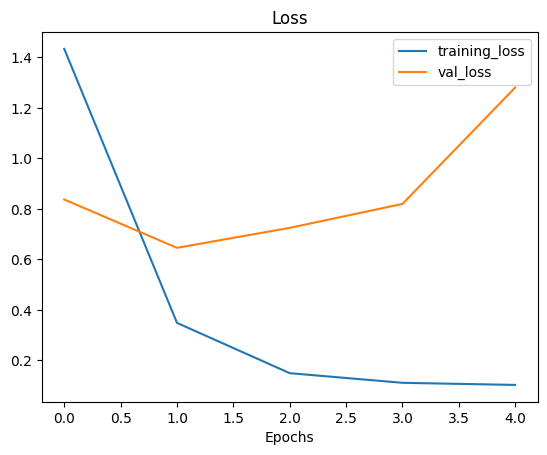

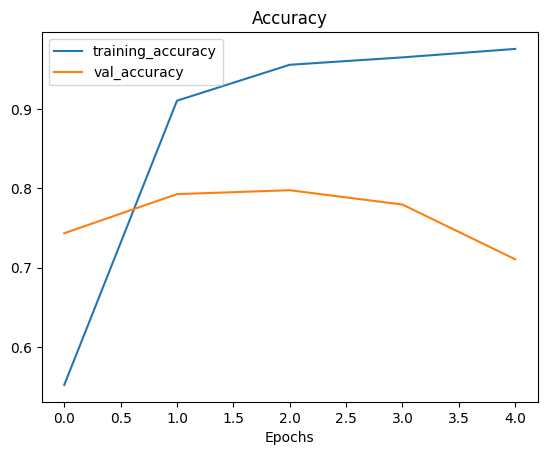

In [ ]:
# Check out our model's curves
plot_loss_curves(history)

## Getting a feature vector from a trained model

Let's demonstrate the Global Averrage Pooling 2D layer...

We have a tensor after our model goes through 'base_model' of shape (None, 7, 7, 1280)...

But then it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similiar shape shaped tensor of (1, 4, 4, 3) and then pass in to GlobalAveragePooling2D

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f'Random tensor:\n {input_tensor} \n')

# Pass the tensor to a Global Average Pooling 2D
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D GAP tensor:  \n {global_average_pooled_tensor} \n')

# Check the shape
print(f'Input Shape: {input_tensor.shape} \n')
print(f'2D GAP Shape: {global_average_pooled_tensor.shape} \n')

Random tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D GAP tensor:  
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Input Shape: (1, 4, 4, 3) 

2D GAP Shape: (1, 3) 



In [ ]:
# Let's repliacte the GAP 2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

1. model-1 - Feature extraction on 1% of the data with data augmentation
2. model-2 - Feature extraction on 10% of the data with data augmentation
3. model-3 - Fine-Tuning on 10% of the data with data augmentation
4. model-4 - Fine-Tuning on 100% with data augmentation

### Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip
unzip_data('10_food_classes_1_percent.zip')

--2023-08-25 08:37:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.128, 64.233.183.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   208MB/s    in 0.6s    

2023-08-25 08:37:55 (208 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [ ]:
# Create train and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [ ]:
# How many images are we working with
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There a

In [ ]:
# Setup Data Loaders
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name='data_augmentation')

### Visualize our data augmentation layer

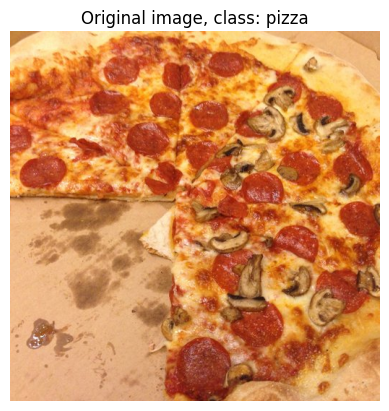

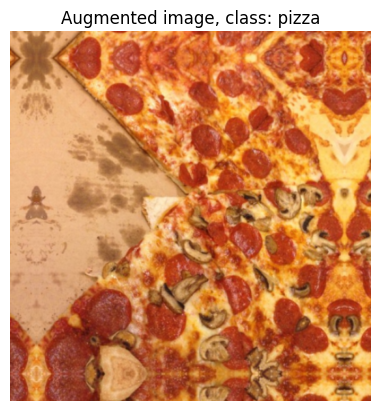

In [ ]:
# View a random imgae and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_path = random.choice(os.listdir(target_dir))
random_image = target_dir + '/' + random_path

# Read in the random image
img = mpimg.imread(random_image)
plt.title(f'Original image, class: {target_class}')
plt.axis(False)
plt.imshow(img);

# Plot Augmented image
augmented_img = data_augmentation(img, training=True)

plt.figure()
plt.title(f'Augmented image, class: {target_class}')
plt.axis(False)
plt.imshow(augmented_img/255.)

## Model 1: Feature extraction on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='1_percent_data')])

Saving TensorBoard log files to: transfer_learning/1_percent_data/20230825-083800
Epoch 1/5
3/3 [==============================] - 13s 2s/step - loss: 2.4554 - accuracy: 0.0857 - val_loss: 2.2138 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1813 - accuracy: 0.1857 - val_loss: 2.1022 - val_accuracy: 0.2648
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0083 - accuracy: 0.2429 - val_loss: 2.0004 - val_accuracy: 0.3487
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8206 - accuracy: 0.4714 - val_loss: 1.9070 - val_accuracy: 0.4046
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6660 - accuracy: 0.6857 - val_loss: 1.8230 - val_accuracy: 0.4441


In [ ]:
# Evaluate model
results_1_percent_data = model_1.evaluate(test_data)
results_1_percent_data

79/79 [==============================] - 7s 88ms/step - loss: 1.8430 - accuracy: 0.4340


[1.842965841293335, 0.4339999854564667]

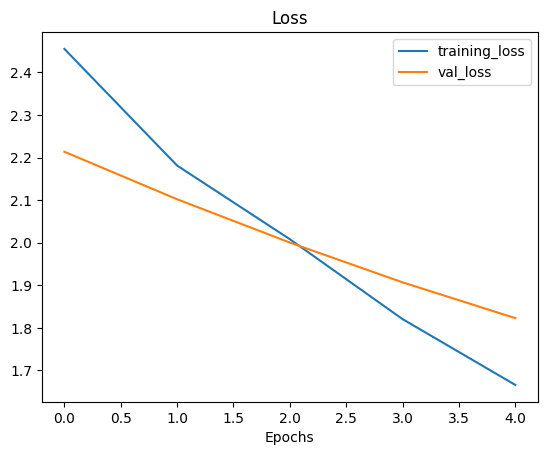

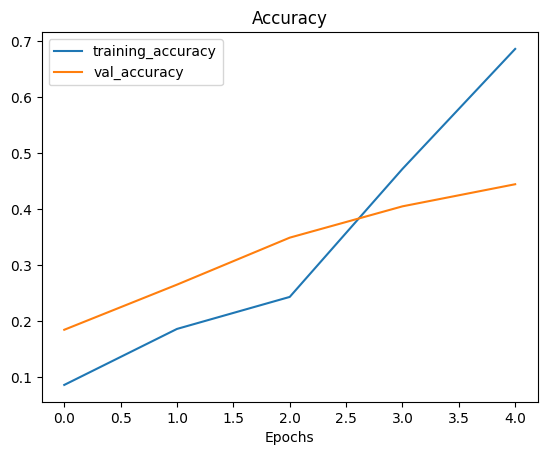

In [ ]:
# How do the model with 1% of the data
plot_loss_curves(history_1)

## Model 2: feature extration transfer learning model with 10% of the data augmentation

In [ ]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [ ]:
# Create data loads
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name='data_augmentation')

# Setup the input shape
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
# Create the inputs and the outputs
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False) # Pass the augmentation images but keep it in inference mode, this also insures batchnorm layers don't get updated.
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)

outputs = layers.Dense(10, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create a ModelCheckpoint callback

The ModelCheckpoint callback saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = '10_percent_model_checkpoints_weight/checkpoint.ckpt'

# Create a ModelCheckpoint calllback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weight_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         save_format='tf',
                                                         verbose=1)

Starting with TF 2.10, None of the effientnet models loaded from keras applications can be serialized. The code above + EfficientNetModels, works for TF 2.9 but fails for 2.10, 2.11 and 2.12.

In [ ]:
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='10_percent_data_2')])

Saving TensorBoard log files to: transfer_learning/10_percent_data_2/20230825-083853
Epoch 1/5
24/24 [==============================] - 24s 517ms/step - loss: 2.0624 - accuracy: 0.3253 - val_loss: 1.5046 - val_accuracy: 0.6431
Epoch 2/5
24/24 [==============================] - 10s 403ms/step - loss: 1.3542 - accuracy: 0.6867 - val_loss: 1.0172 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 11s 447ms/step - loss: 1.0300 - accuracy: 0.7387 - val_loss: 0.7927 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 11s 423ms/step - loss: 0.8593 - accuracy: 0.7947 - val_loss: 0.6794 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 15s 595ms/step - loss: 0.7725 - accuracy: 0.8133 - val_loss: 0.6428 - val_accuracy: 0.8339


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 1.1803 - accuracy: 0.7232


[1.1802655458450317, 0.7232000231742859]

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.6236 - accuracy: 0.8444


[0.6235501170158386, 0.8443999886512756]

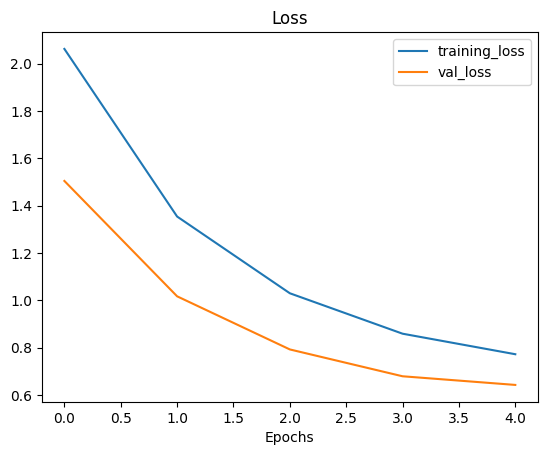

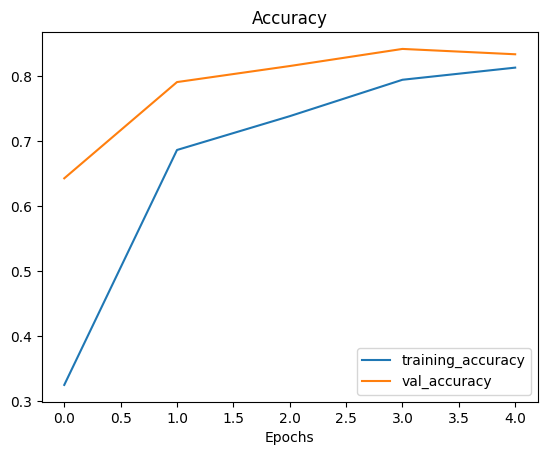

In [ ]:
# Plot model loss curves
plot_loss_curves(history_2)

Starting with TF 2.10, None of the effientnet models loaded from keras applications can be serialized. The code below works for TF 2.9 but fails for 2.10, 2.11 and 2.12.

### Loading in checkpointed weights

Loading in checkpointedweights returns a model to a specific checkpoint

Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_paths)

## Model 3: Fine-Tuning an existing model on 10% of the data

**NOTE:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x78ef604f1e40> True
<keras.engine.sequential.Sequential object at 0x78ef39d0b8e0> True
<keras.engine.functional.Functional object at 0x78ef2f8262c0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x78ef54e8dc30> True
<keras.layers.core.dense.Dense object at 0x78ef2fa3e980> True


In [ ]:
# What layers are in our base_model (EfficientNet)
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_7 False
1 rescaling_9 False
2 normalization_6 False
3 rescaling_10 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fal

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (we have to recompile our models every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate 10x
                metrics=['accuracy'])

In [ ]:
# Check which layers are tunable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 rescaling_9 False
2 normalization_6 False
3 rescaling_10 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fal

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine-tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_tune = model_2.fit(train_data_10_percent,
                                epochs=10,
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                initial_epoch=history_2.epoch[-1])

Epoch 5/10
24/24 [==============================] - 22s 551ms/step - loss: 0.6394 - accuracy: 0.8307 - val_loss: 0.4911 - val_accuracy: 0.8470
Epoch 6/10
24/24 [==============================] - 10s 407ms/step - loss: 0.5153 - accuracy: 0.8533 - val_loss: 0.4666 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 10s 426ms/step - loss: 0.4591 - accuracy: 0.8600 - val_loss: 0.4501 - val_accuracy: 0.8569
Epoch 8/10
24/24 [==============================] - 9s 339ms/step - loss: 0.4035 - accuracy: 0.8773 - val_loss: 0.4801 - val_accuracy: 0.8372
Epoch 9/10
24/24 [==============================] - 9s 343ms/step - loss: 0.3711 - accuracy: 0.8920 - val_loss: 0.4674 - val_accuracy: 0.8454
Epoch 10/10
24/24 [==============================] - 9s 363ms/step - loss: 0.3443 - accuracy: 0.9013 - val_loss: 0.4901 - val_accuracy: 0.8355


In [ ]:
# Evaluate the fine tune model
result_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 83ms/step - loss: 0.4280 - accuracy: 0.8556


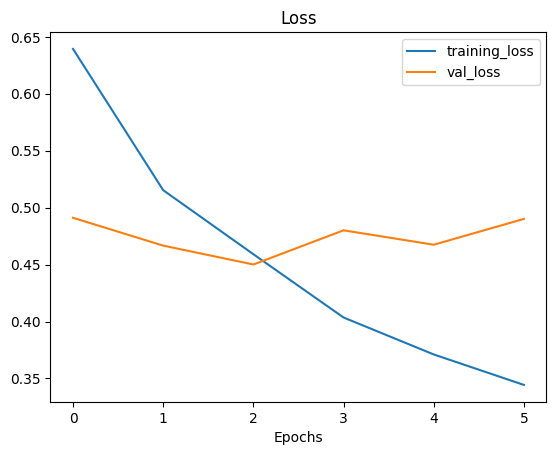

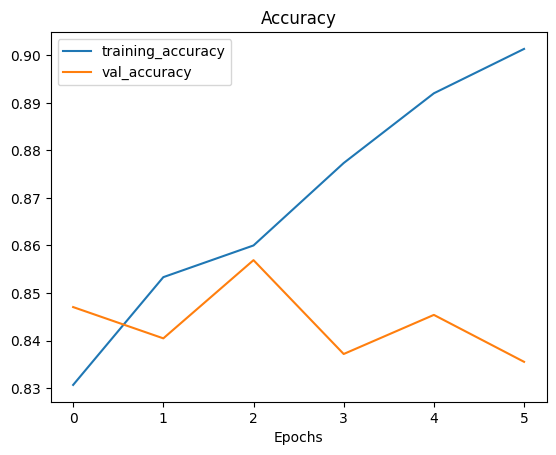

In [ ]:
# Check out the loss curves of the fine tuned model
plot_loss_curves(history_fine_tune)

The 'plot_loss_curves function' works great with model which have only been fitted once, however, we want something to compare one series of running fit() with another.

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensoFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Compare origianl history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Valiadtion Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

   # Make plots loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Valiadtion Loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

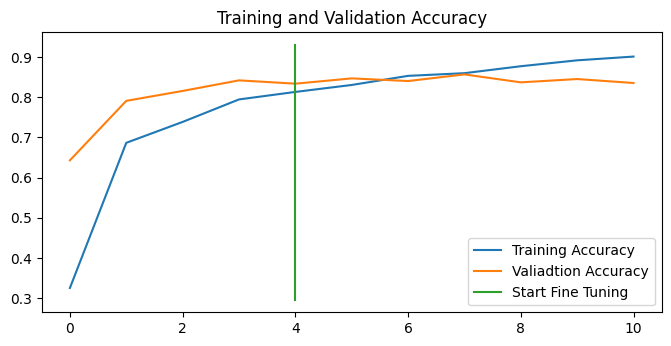

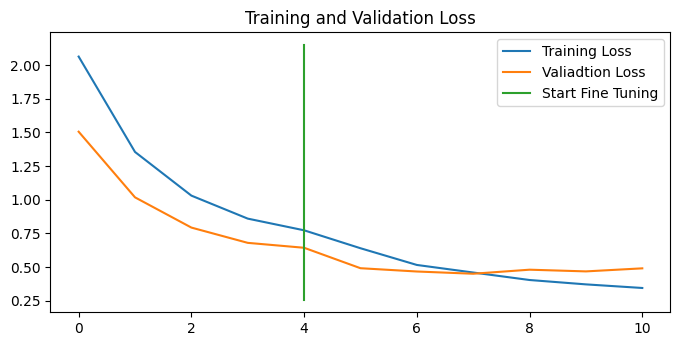

In [ ]:
compare_histories(history_2,
                  history_fine_tune)